<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Looking at Parameter Identifiability

Sensitivity analyses can mask other artifacts that affect calibration and uncertainty. A primary issues is correlation between parameters.  For example, we saw that in a heads-only calibration we can't estimate both recharge and hydraulic conductivity independently - the parameters are correlated so that an increase in one can be offset with an increase in the other.  To address this shortcoming, Doherty and Hunt (2009) show that singular value decomposition can extend the sensitivity insight into __*parameter identifiability*__.  Parameter identifiability combines parameter insensitivity and correlation information, and reflects the robustness with which particular parameter values in a model might be calibrated. That is, an identifiable parameter is both sensitive and relatively uncorrelated and thus is more likely to be estimated (identified) than an insensitive and/or correlated parameter. 

Parameter identifiability is considered a "linear method" in that it assumes the Jacobian matrix sensitivities hold over a range of reasonable parameter values.  It is able to address parameter correlation through singular value decomposition (SVD), exactly as we've seen earlier in this course.  Parameter identifiability ranges from 0 (perfectly unidentifiable with the observations available) to 1.0 (fully identifiable). So, we typically plot identifiability using a stacked bar chart which is comprised of the included singular value contributions. Another way to think of it: if a parameter is strongly in the SVD solution space (low singular value so above the cutoff) it will have a higher identifiability. However, as Doherty and Hunt (2009) point out, identifiability is qualitative in nature because the singular value cutoff is user specified. 

You can access parameter identifiability at the command line using the PEST utility __*identpar*__.  As always, when you type identpar without arguments you'll get what the utility needs to run. For identpar.exe it looks like:



    IDENTPAR Version 14.01. Watermark Numerical Computing.


    IDENTPAR is run using the command:

        IDENTPAR casename numvec outbase matfile identfile [/s or /r]

    where

        casename  is a PEST control file basename,
        numvec    is the number of singular values to use,
        outbase   is the filename base of sensitivity vector output files,
        outfile   is the name of a matrix output file
        identfile is the name of a parameter identifiability output file, and
        /s or /r  instigates SVD on XtQX or Q^(1/2)X respectively (/s is default).

        Note: enter a filename of "null" for no pertinent output file.


The input of __numvec__ specifies the singular value cutoff that is used to calculate identifiability; the __identfile__ above provides the output in a format suitable for plotting.  

However, in our example here __we won't use the command line PEST utility__ but will instead take advantage of the pyemu version of parameter identifiability for convenience. Let's take a look at it more closely and see what we can learn from it and how to handle such information as the number of parameters rises.

### One last cool concept about identifiability the Doherty and Hunt (2009) point out:  
Because parameter identifiability uses the Jacobian matrix it is the *sensitivity* that matters, not the actual value specified. This means you can enter *hypothetical observations* to the existing observations, re-run the Jacobian matrix, and then re-plot identifiability. In this way identifiability becomes a quick but qualitative way to look at the worth of future data collection - an underused aspect of our modeling!   

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import pyemu
import os, shutil
import re
from matplotlib.backends.backend_pdf import PdfPages
runall= False
import identifiability_helper as ih

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'inschek', 'inschek.exe', 'kzone.ref', 'mf2005', 'mf2005.exe', 'mfnwt', 'mp6', 'mp6.exe', 'mpath.in', 'obs_loc.csv', 'pest++.exe', 'pestchek', 'pestchek.exe', 'pestpp', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'sweep', 'sweep.exe', 'tempchek', 'tempchek.exe', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following 

In [3]:
obslox = pd.read_csv(os.path.join(working_dir,'freyberg.hyd'), delim_whitespace=True, usecols = [4,5,6], 
                     index_col=2, skiprows = 1, header=None, names=['X','Y','obsname'])
obslox = obslox.drop([i for i in obslox.index if not i.startswith('cr')], axis=0)
parlox = pd.read_csv(os.path.join(working_dir,'hkpp.dat.tpl'), delim_whitespace=True, usecols=[0,1,2],
                    index_col=0, skiprows=1, header=None, names=['parname','X','Y'])
parlox['pp_num'] = [re.findall('\d+',i)[0] for i in parlox.index.values]
parlox.index=['hk{}'.format(i[-2:]) for i in parlox.index]
parlox

,X,Y,pp_num
hk00,125.0,9875.0,0000
hk01,1125.0,9875.0,0001
hk02,2125.0,9875.0,0002
hk03,3125.0,9875.0,0003
hk04,4125.0,9875.0,0004
hk05,125.0,8875.0,0005
hk06,1125.0,8875.0,0006
hk07,2125.0,8875.0,0007
hk08,3125.0,8875.0,0008
hk09,4125.0,8875.0,0009


# We need to calculate a Jacobian Matrix to look at sensitivity and identifiability

## we just need to sen `NOPTMAX=-1` in the PST control file and run PESTPP

In [4]:
inpst = pyemu.Pst(os.path.join(working_dir,'freyberg_pp.pst'))
inpst.control_data.noptmax=-1
inpst.write(os.path.join(working_dir,'freyberg_jac.pst'))

In [5]:
if runall==True:
    os.chdir(working_dir)
    pyemu.helpers.run('pestpp freyberg_jac.pst')
    os.chdir('..')
else:
    shutil.copy2('freyberg_jac.jcb', os.path.join(working_dir,'freyberg_jac.jcb'))

# Let's load up the resulting Jacobian and look at sensitivity and identifiability

## Make a Linear Anlysis object in `pyemu`

In [6]:
la = pyemu.LinearAnalysis(jco=os.path.join(working_dir,'freyberg_jac.jcb'))

## among other things, this loads the Jacobian matrix (called `jco`) as a property

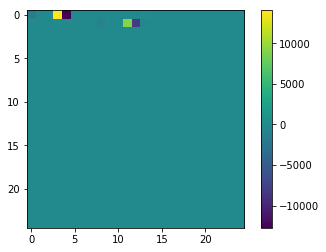

In [7]:
plt.imshow(la.jco.x[:25,:25].T)
plt.colorbar()


/Users/mnfienen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


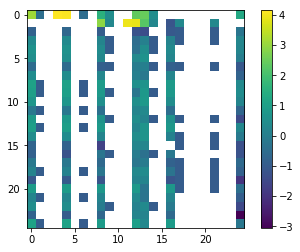

In [8]:
plt.imshow(np.log10(np.abs(la.jco.x[:25,:25].T)))
plt.colorbar()

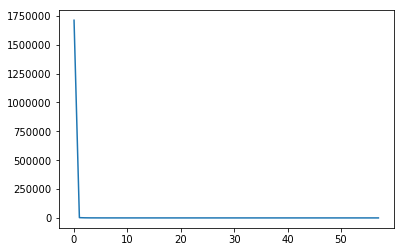

In [9]:
svals = la.xtqx.s
plt.plot(svals.x)

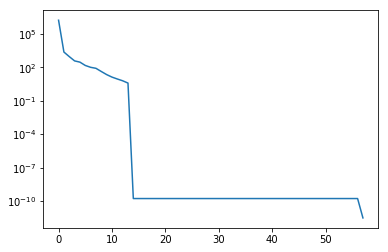

In [10]:
plt.plot(svals.x)
plt.yscale('log')

# To look at identifiability we will need to create an `ErrVar` object in `pyemu`

In [11]:
ev = pyemu.ErrVar(jco=os.path.join(working_dir,'freyberg_jac.jcb'))

## We can get a dataframe of identifiability for any singular value cutoff

In [12]:
id_df = ev.get_identifiability_dataframe(singular_value=5).sort_values(by='ident', ascending=False)
id_df.head()

,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,ident
rch_0,9.737176e-01,0.009020,0.000117,0.000325,0.000010,0.983189
w0_r34_c12,2.968225e-03,0.011258,0.050925,0.172456,0.298143,0.535750
hk08,1.370568e-06,0.093330,0.168532,0.137990,0.025340,0.425193
hk06,6.622997e-09,0.028106,0.000317,0.179567,0.101656,0.309646
w0_r09_c16,1.495368e-02,0.257500,0.012491,0.003560,0.006349,0.294855


## It's easy to visualize these as stacked bar charts

In [13]:
id = ih.plot_id_bars(ev, 150)

## More meaningful to look at a singular value cutoff

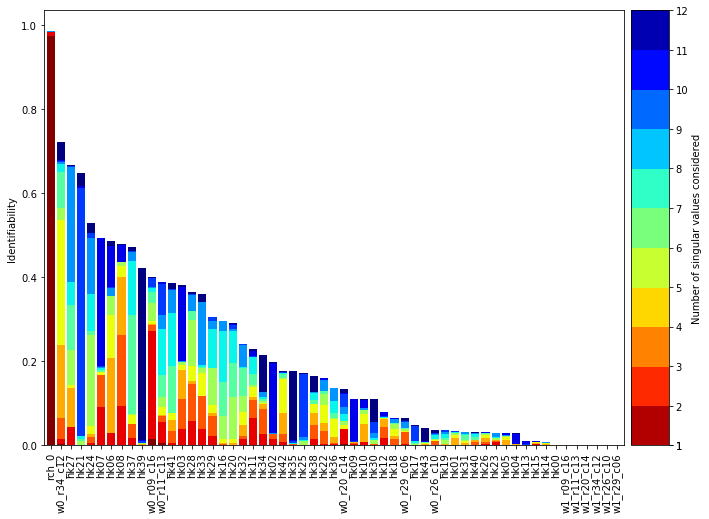

In [14]:
id = ih.plot_id_bars(ev, 12)

## How does this compare with CSS (Composite Scaled Sensitivities)?

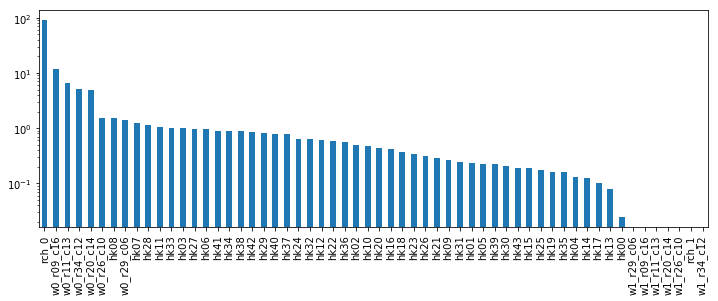

In [15]:
plt.figure(figsize=(12,4))
ax = la.get_par_css_dataframe()['pest_css'].sort_values(ascending=False).plot(kind='bar')
ax.set_yscale('log')

## We can read in the covariance and look at correlation

In [16]:
sc = pyemu.Schur(os.path.join(working_dir, 'freyberg_jac.jcb'))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df().head()

,rch_0,rch_1,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
rch_0,1.667248e+06,1.502401e-47,1.939575e+01,9.658997e+01,-6.017767e+02,-1.324242e+03,-1.566090e+02,-2.625004e+01,-1.790950e+02,-1.497391e+03,...,-8.818860e+04,-2.737106e+04,-2.428909e+04,-9.202440e+04,-3.739020e-48,-1.845823e-48,-1.763085e-48,-3.327131e-49,-2.466268e-49,-1.531123e-48
rch_1,1.502401e-47,9.799090e-46,-1.207960e-51,1.321481e-50,-3.345374e-50,-1.230899e-49,-4.783226e-50,5.192461e-50,1.600510e-49,4.426064e-51,...,-1.743061e-49,-2.362503e-49,-3.515412e-49,-4.471106e-49,-1.093895e-46,-5.431374e-47,-5.165494e-47,-9.943228e-48,-7.498114e-48,-4.499639e-47
hk00,1.939575e+01,-1.207960e-51,1.157824e-01,2.458702e-01,-2.147939e+00,-4.584293e+00,-5.207399e-01,-2.273970e-01,-1.228925e+00,-5.542998e+00,...,1.445488e+00,1.487013e-01,-1.654812e-01,1.124021e+00,4.331631e-52,2.152916e-52,2.006588e-52,2.740229e-53,5.399045e-54,9.414993e-54
hk01,9.658997e+01,1.321481e-50,2.458702e-01,1.104932e+01,2.867547e+00,-1.778478e+01,-2.306477e+00,9.506091e+00,3.820974e+01,5.705182e+00,...,-1.503047e+01,-1.073871e+00,2.423083e+00,-1.081240e+01,-5.233734e-51,-2.615897e-51,-2.414673e-51,-2.983096e-52,6.188757e-54,4.548452e-52
hk02,-6.017767e+02,-3.345374e-50,-2.147939e+00,2.867547e+00,4.784205e+01,7.881621e+01,8.452346e+00,1.056331e+01,4.846209e+01,1.185157e+02,...,-2.354359e+01,2.178322e-01,7.546220e+00,-1.608253e+01,5.691878e-51,2.760457e-51,2.767784e-51,7.700365e-52,9.281711e-52,6.410998e-51


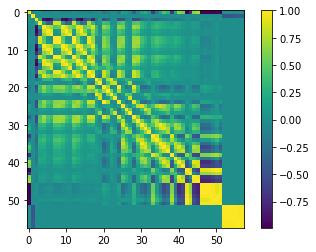

In [17]:
R = covar.to_pearson()
plt.imshow(R.df(), interpolation='nearest', cmap='viridis')
plt.colorbar()

### Let's look at correlation
CSS suffers from the challenge that values with high CSS may be corelated with other parameters. We can check that out. Identifiability, on the other hand, tends to spread among the correlated parameters so that identifiability is suppressed from each of those parameters. This makes a big difference between what is "sensitive" vs. "identifiable"

In [18]:
cpar = 'hk08'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5]

hk00   -0.978481
hk02    0.859996
hk03    0.995744
hk04    0.891160
hk07    0.885708
hk08    1.000000
hk09    0.778941
hk11    0.806815
hk12    0.992717
hk13    0.625143
hk15    0.706106
Name: hk08, dtype: float64

## this is also good look at spatially

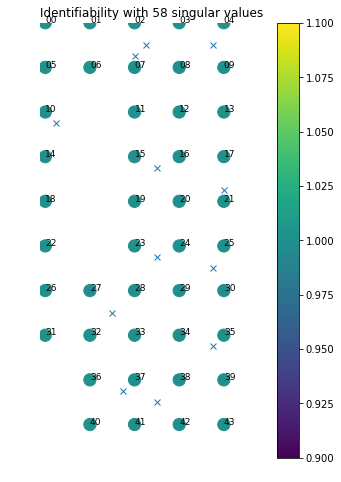

In [23]:
ih.plot_identifiability_spatial(ev, 58, parlox, obslox, True)